In [31]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from utils import replace_relu_with_qcfs, replace_qcfs_with_sn
from modules import reset_net, IF, GN, PGN
import matplotlib.pyplot as plt
import copy
import numpy as np
from funcs import seed_all
seed_all(99)

N = 16
B = 4096*2
L = 8
TAU = 4
T = L * 4
SIGMA = 0.8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
99


In [32]:
net = nn.Sequential(nn.ReLU(), nn.Linear(N, N), nn.ReLU())
def make_model():
	return copy.deepcopy(net)

X = torch.rand(B, N)
Y = make_model()(X)

def run_exp(model: nn.Module):
	reset_net(model)
	loss_fn = nn.MSELoss()
	loss_history = []
	spikes_history = []
	spikes_sum = torch.zeros_like(Y)
	for t in range(1, T + 1):
		spikes_sum += model(X)
		activation = spikes_sum / t
		loss_val: float = loss_fn(activation, Y).mean(dim=0).detach().item()
		loss_history.append(loss_val)
		spikes_history.append(model[-1].spikes.int())
	return loss_history, torch.stack(spikes_history)

In [33]:
model = make_model()
model = replace_relu_with_qcfs(model, L=L)
model = replace_qcfs_with_sn(model, TAU, "if", noise=SIGMA)
loss_history_if, _ = run_exp(model)

In [34]:
model = make_model()
model = replace_relu_with_qcfs(model, L=L)
model = replace_qcfs_with_sn(model, TAU, "gn", noise=SIGMA)
loss_history_gn, _ = run_exp(model)

In [35]:
model = make_model()
model = replace_relu_with_qcfs(model, L=L)
model = replace_qcfs_with_sn(model, TAU, "pgn", noise=SIGMA)
loss_history_pgn, _ = run_exp(model)

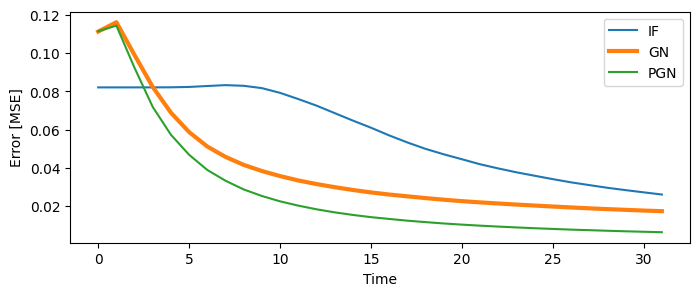

In [36]:
plt.figure(figsize=(8, 3))
plt.plot(loss_history_if, label='IF')
plt.plot(loss_history_gn, label='GN', lw=3)
plt.plot(loss_history_pgn, label='PGN')
plt.ylabel('Error [MSE]')
plt.xlabel('Time')
plt.legend();